A notebook which contains an evaluation of the SalishSeaCast model within PugetSound for the year 2009. More specifically, it compares Observed data on chlorophyll concentrations collected from bottle data and compares it to various model phytoplankon outputs. This evaluation includes scatter plots visualizing the similarity of observed and model data as well as tables of evaluation statistics.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=range(2007,2020)
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Year: '''+ str(years)))

## Year: range(2007, 2020)

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of chlorophyll between 201905 runs and Pheo observations

In [6]:
##### Loading in pickle file data
dictbot=dict()
saveloc='/ocean/kflanaga/MEOPAR/savedData'

for Y in years:
    with open(os.path.join(saveloc,f'data_Pheo_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictbot[Y]=pickle.load(hh)
    
data_Pheo=pd.concat(dictbot.values(), ignore_index=True)

In [7]:
#Adding extra columns to assist in analysis.

Chl_to_N=1.8
data_Pheo['log_Chl']=ket.logt(data_Pheo['Chla_Lab'])
data_Pheo['log_mod_diatoms']=ket.logt(data_Pheo['mod_diatoms']*Chl_to_N)
data_Pheo['log_mod_ciliates']=ket.logt(data_Pheo['mod_ciliates']*Chl_to_N)
data_Pheo['log_mod_flagellates']=ket.logt(data_Pheo['mod_flagellates']*Chl_to_N)
data_Pheo['mod_Chl']=((data_Pheo['mod_diatoms']*Chl_to_N)+(data_Pheo['mod_ciliates']*Chl_to_N)+(data_Pheo['mod_flagellates']*Chl_to_N))
data_Pheo['log_mod_Chl']=ket.logt((data_Pheo['mod_diatoms']*Chl_to_N)+(data_Pheo['mod_ciliates']*Chl_to_N)+(data_Pheo['mod_flagellates']*Chl_to_N))

# defning a dictionary that brakes the data down by individual stations
datstat_Pheo=dict()
for ind, istation in enumerate(data_Pheo.Station.unique()):
    datstat_Pheo[istation]=data_Pheo.loc[data_Pheo.Station == istation]

datreg_Pheo=dict()
for iregion in data_Pheo.Basin.unique():
    datreg_Pheo[iregion] = data_Pheo.loc[data_Pheo.Basin==iregion] 

In [8]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz=(data_Pheo.Z<15)
DJFd=dict()
MAMd=dict()
JJAd=dict()
SONd=dict()
for i in range(2008,2020):
    DJFd[i]=data_Pheo.loc[iz&(data_Pheo.dtUTC>=dt.datetime(i-1,12,1))&(data_Pheo.dtUTC<=dt.datetime(i,3,1)),:]
    MAMd[i]=data_Pheo.loc[iz&(data_Pheo.dtUTC<=dt.datetime(i,6,1))&(data_Pheo.dtUTC>dt.datetime(i,3,1)),:]
    JJAd[i]=data_Pheo.loc[iz&(data_Pheo.dtUTC<=dt.datetime(i,9,1))&(data_Pheo.dtUTC>dt.datetime(i,6,1)),:]
    SONd[i]=data_Pheo.loc[iz&(data_Pheo.dtUTC>dt.datetime(i,9,1))&(data_Pheo.dtUTC<=dt.datetime(i,11,30)),:]
DJF_Pheo=pd.concat(DJFd.values(), ignore_index=True)
MAM_Pheo=pd.concat(MAMd.values(), ignore_index=True)
JJA_Pheo=pd.concat(JJAd.values(), ignore_index=True)
SON_Pheo=pd.concat(SONd.values(), ignore_index=True)

In [9]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs_Pheo=OrderedDict({'z < 15 m':data_Pheo.loc[data_Pheo.Z<15],
                      '15 m < z < 22 m':data_Pheo.loc[(data_Pheo.Z>=15)&(data_Pheo.Z<22)],
                      'z >= 22 m':data_Pheo.loc[data_Pheo.Z>=22],
                      'z > 50 m':data_Pheo.loc[data_Pheo.Z>50],
                      'all':data_Pheo,
                      'z < 15 m, JFM':DJF_Pheo,
                      'z < 15 m, Apr':MAM_Pheo,
                      'z < 15 m, MJJA':JJA_Pheo,
                      'z < 15 m, SOND': SON_Pheo,})
for iregion in data_Pheo.Basin.unique():
    statsubs_Pheo[iregion]=datreg_Pheo[iregion]
statsubs_Pheo.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Main Basin', 'Hood Canal Basin', 'Strait of Juan de Fuca', 'Strait of Georgia', 'Whidbey Basin', 'Admiralty Inlet', 'South Basin'])

## Map of observation locations in each basin

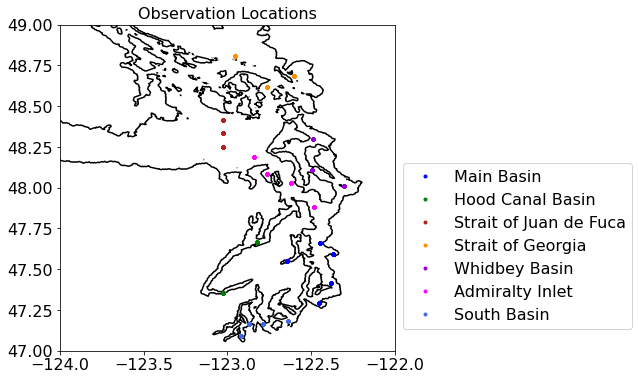

In [10]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data_Pheo.Basin.unique()):
    ax.plot(datreg_Pheo[iregion]['Lon'], datreg_Pheo[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Chlorophyll

# Observed Chlorophyll vs Model Phytoplankton

## Model Diatoms vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets

In [11]:
#Setting variables for Chlorophyll.
obsvar='Chla_Lab'
modvar='mod_diatoms'
seasons=[DJF_Pheo,MAM_Pheo,JJA_Pheo,SON_Pheo]

In [12]:
statsDict_Chl=dict()
statsDict_Chl['Diatoms']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl['Diatoms'][isub]=dict()
    var=statsDict_Chl['Diatoms'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['Diatoms'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

## Model diatoms vs observed chlrophyll by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

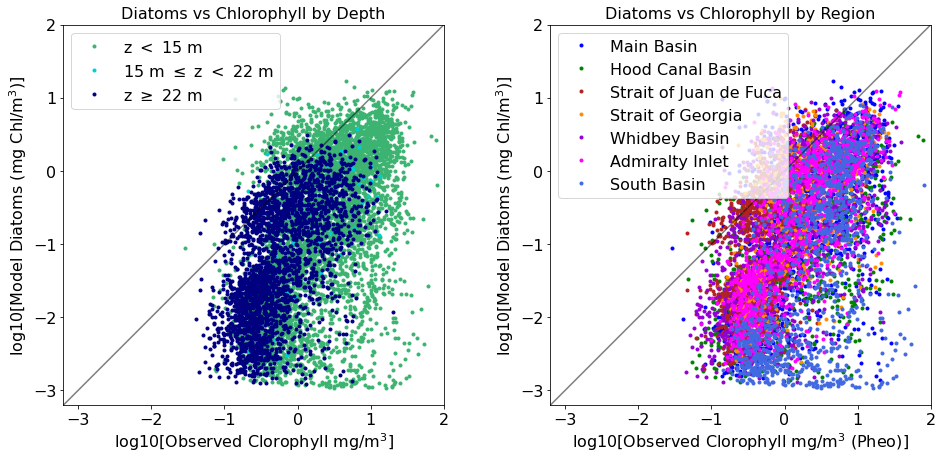

In [13]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,mv)
ax[0].set_title('Diatoms vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$]')   

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,mv)
ax[1].set_title('Diatoms vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

## 2D histogram of modeled vs observed data

Text(0.5, 37.0, 'log10[Observed Clorophyll mg/m$^3$]')

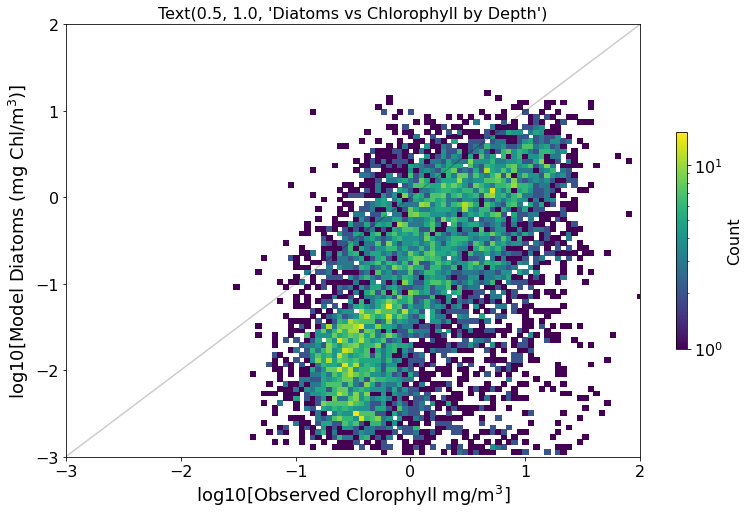

In [14]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data_Pheo,obsvar,modvar,(-3,2),fontsize=18)
ax.set_title(ax.set_title('Diatoms vs Chlorophyll by Depth'))
ax.set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$]')

### Model vs Observed comparisons for individual regions

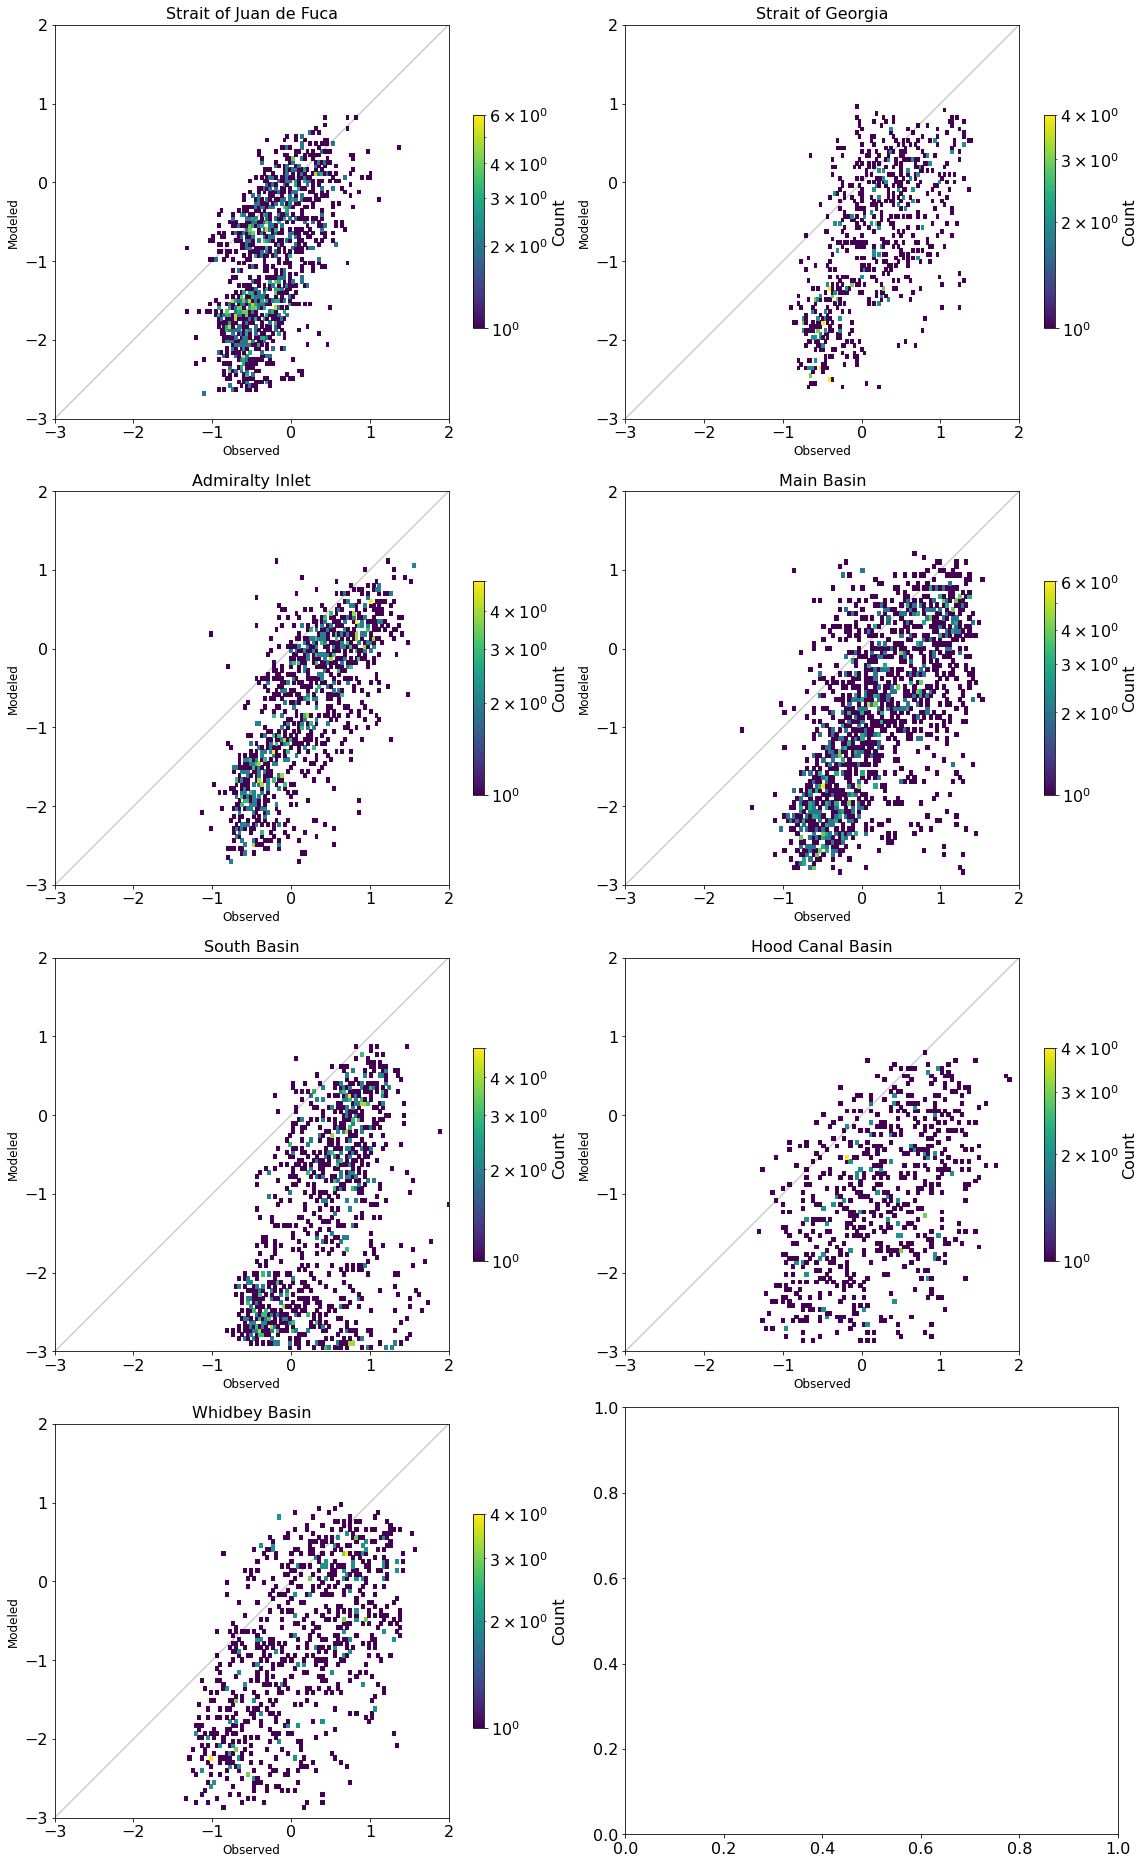

In [15]:
# Should alter to by region 2d histograms.
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(-3,2)
ax=ket.byRegion_hist2d(datreg_Pheo,regions,obsvar,modvar,lims)

### Model vs Observed comparisons for individual seasons

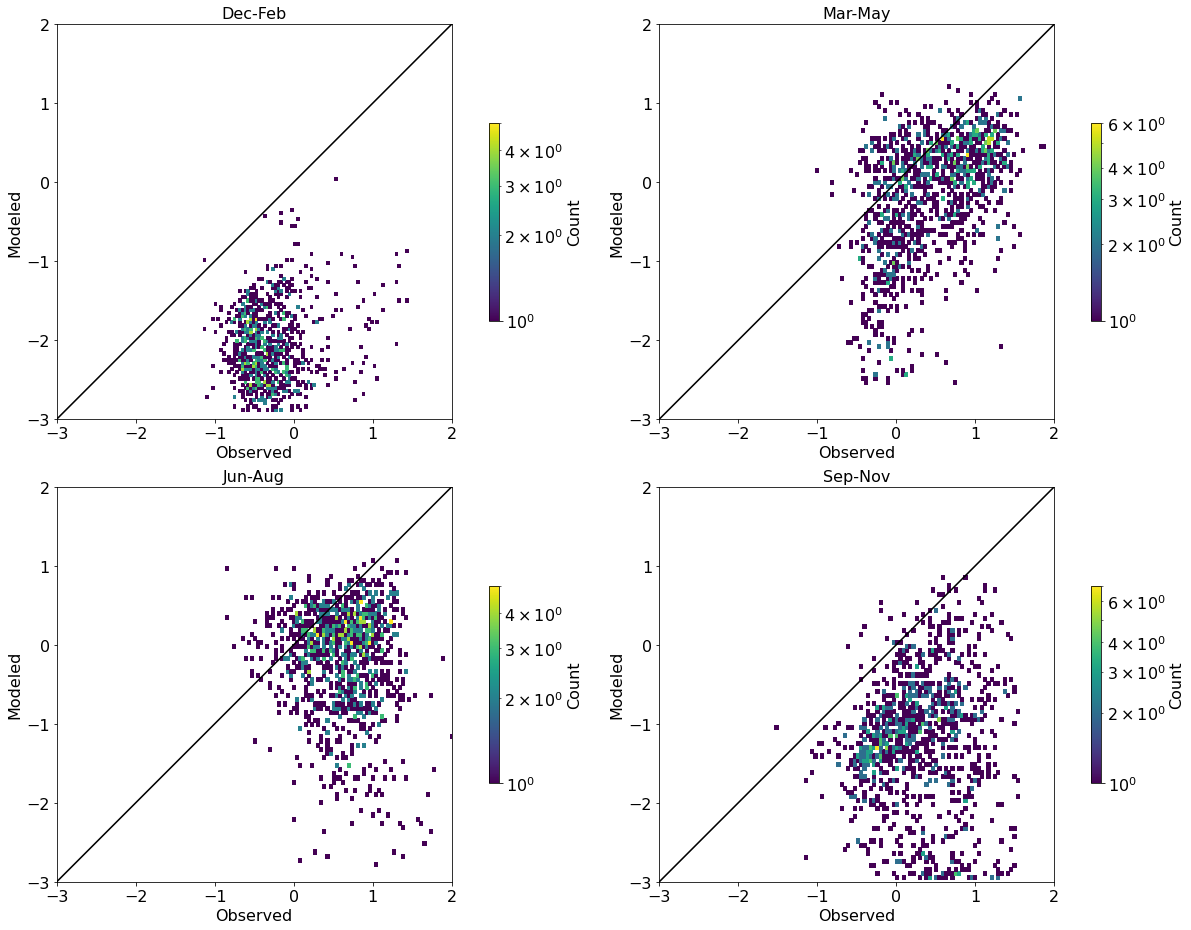

In [16]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(-3,2))
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

## Model Ciliates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [17]:
obsvar='Chla_Lab'
modvar='mod_ciliates'

statsDict_Chl['Ciliates']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl['Ciliates'][isub]=dict()
    var=statsDict_Chl['Ciliates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['Ciliates'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

## Model ciliates vs observed chlrophyll by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

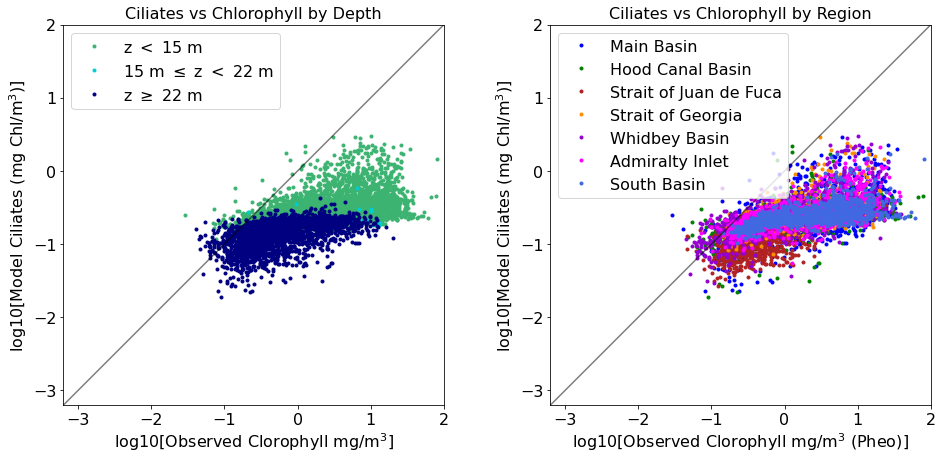

In [18]:
obsvar='log_Chl'
modvar='log_mod_ciliates'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,mv)
ax[0].set_title('Ciliates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$]')   

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,mv)
ax[1].set_title('Ciliates vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

## 2D histogram of modeled vs observed data

Text(0.5, 37.0, 'log10[Observed Clorophyll mg/m$^3$]')

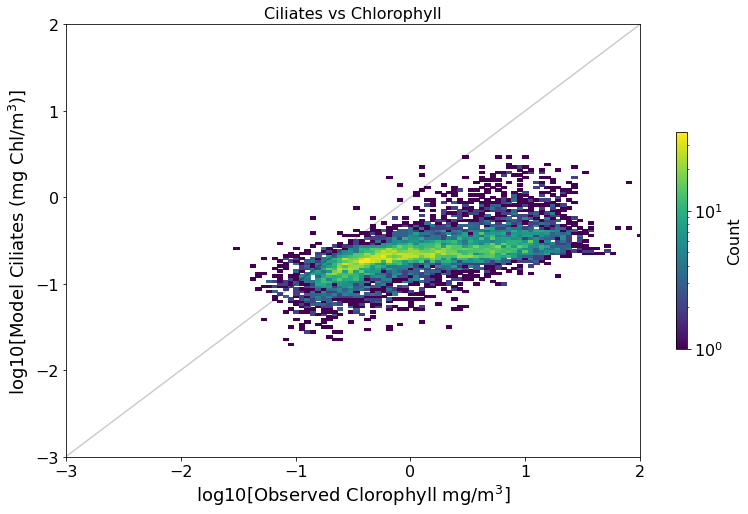

In [19]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data_Pheo,obsvar,modvar,(-3,2),fontsize=18)
ax.set_title('Ciliates vs Chlorophyll')
ax.set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$]')  

### Model vs Observed comparisons for individual regions

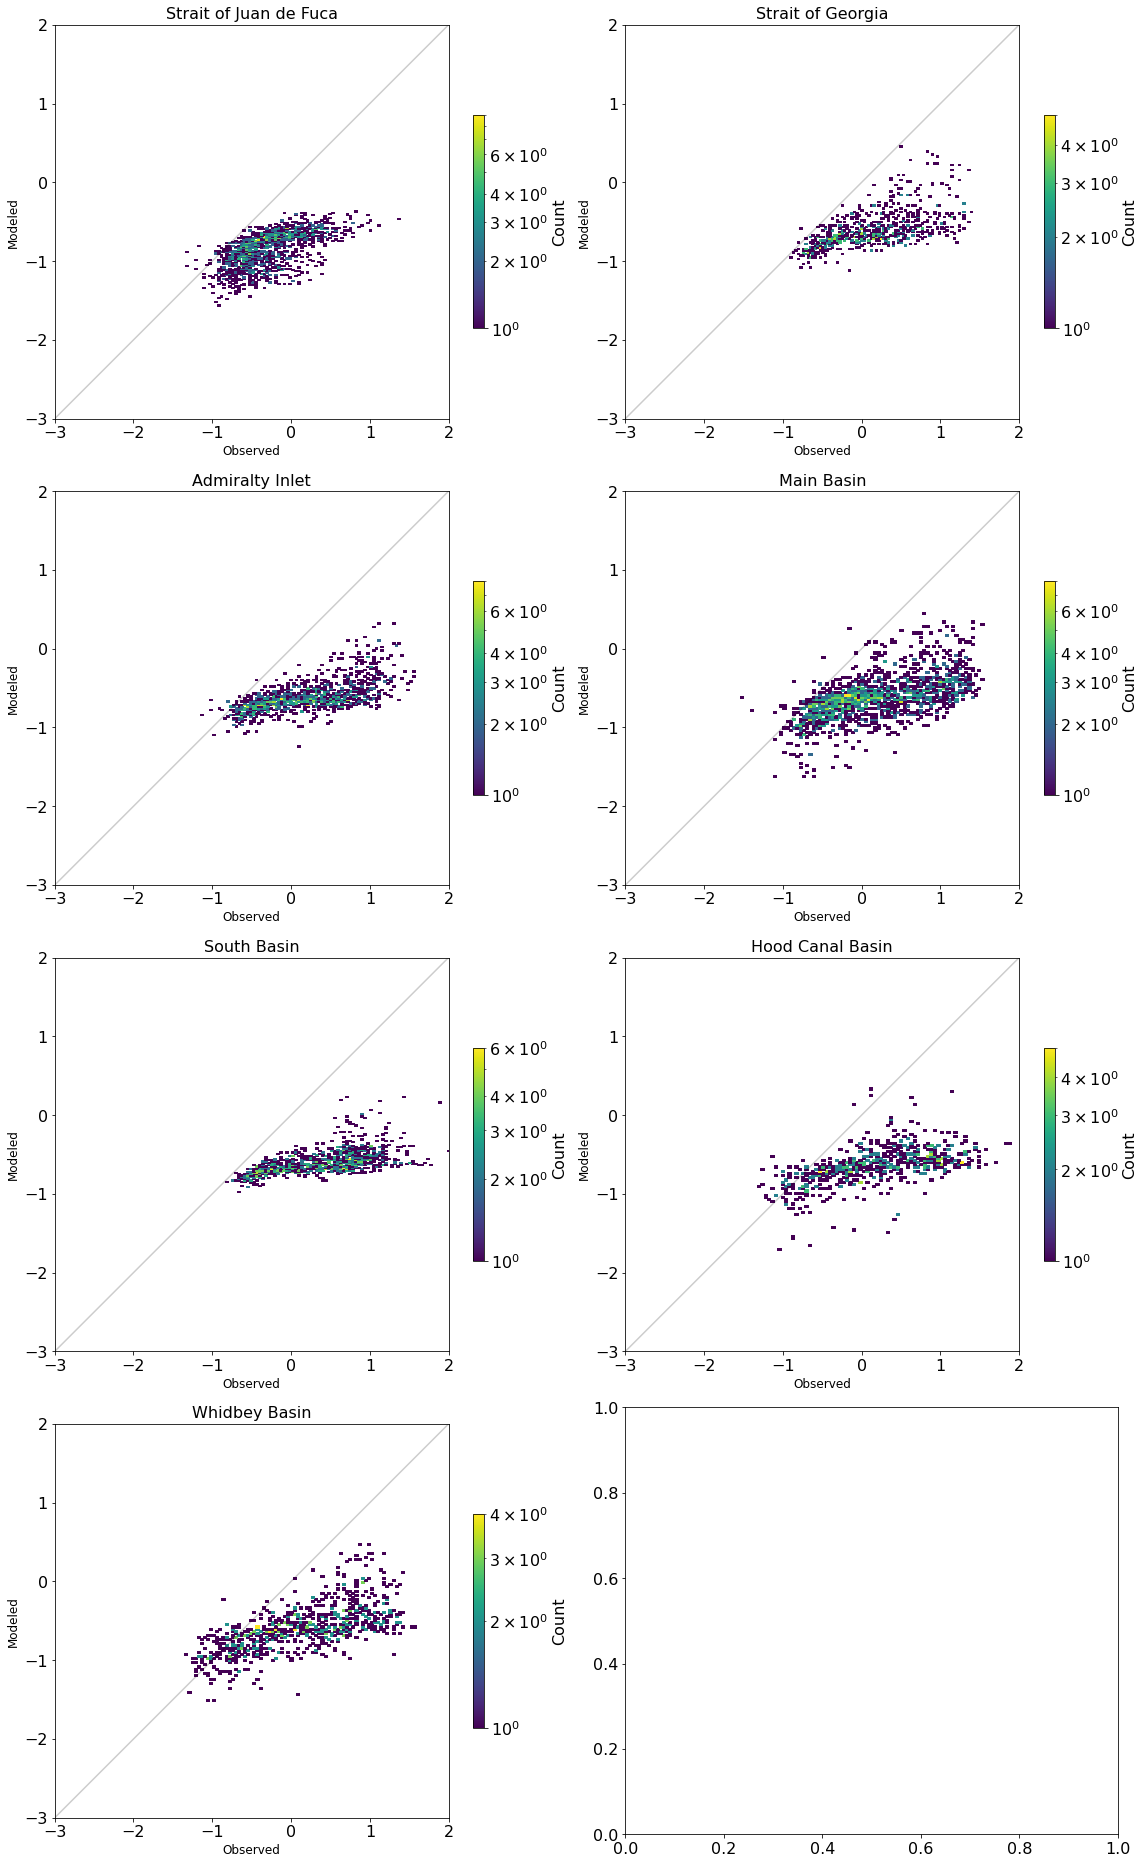

In [20]:
# Should alter to by region 2d histograms.
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(-3,2)
ax=ket.byRegion_hist2d(datreg_Pheo,regions,obsvar,modvar,lims)

### Model vs Observed comparisons for individual seasons

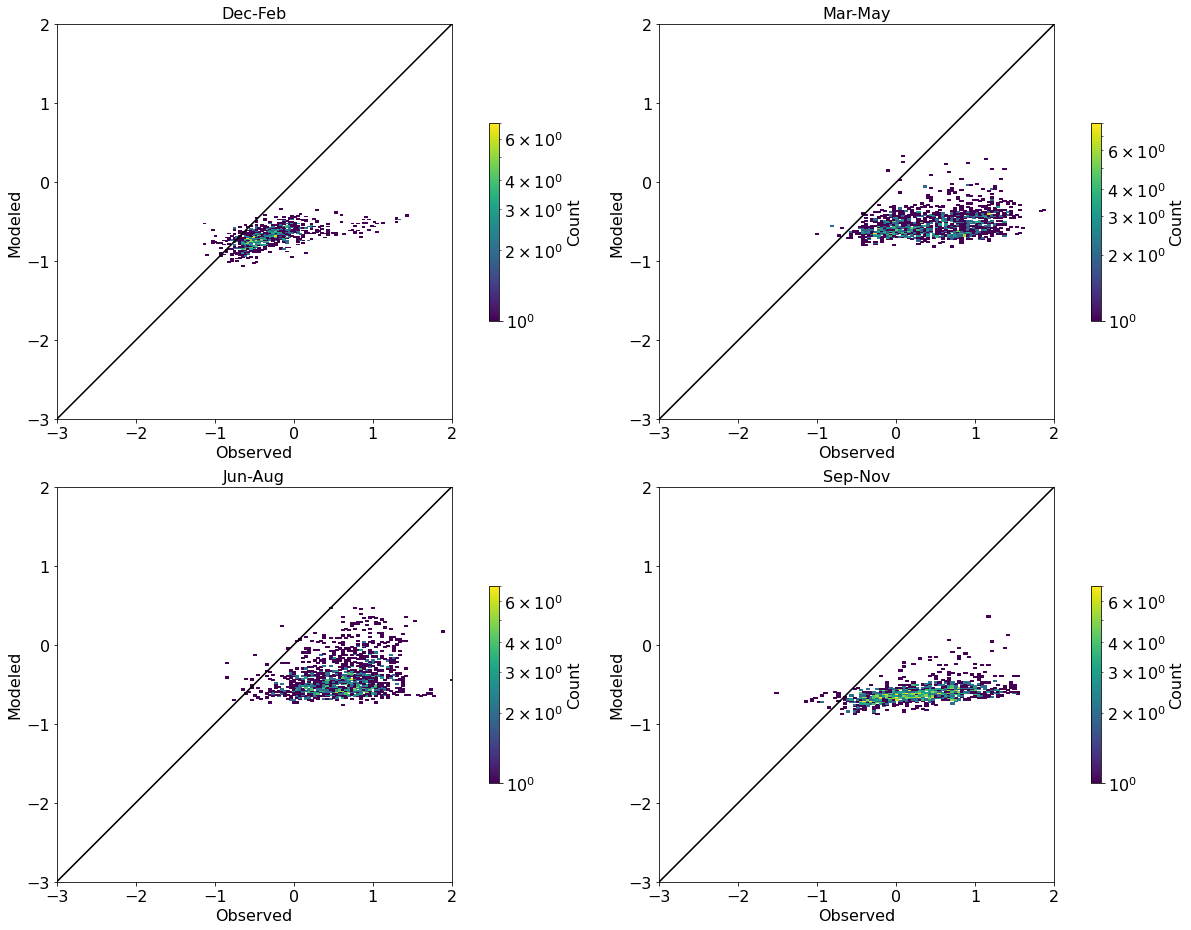

In [21]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(-3,2))
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

## Model Flagellates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [22]:
obsvar='Chla_Lab'
modvar='mod_flagellates'

statsDict_Chl['Flagellates']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl['Flagellates'][isub]=dict()
    var=statsDict_Chl['Flagellates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['Flagellates'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

## Model Flagellates vs observed chlrophyll by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

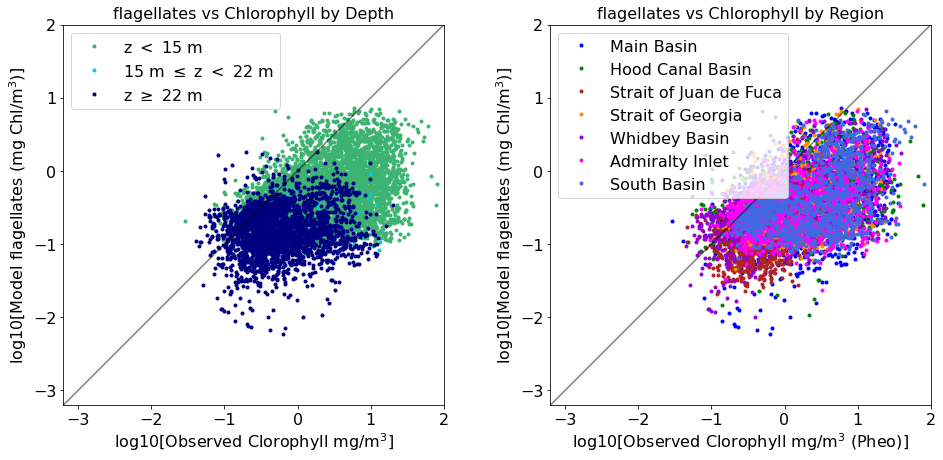

In [23]:
obsvar='log_Chl'
modvar='log_mod_flagellates'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,mv)
ax[0].set_title('flagellates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model flagellates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$]')   

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,mv)
ax[1].set_title('flagellates vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Model flagellates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

## 2D histogram of modeled vs observed data

Text(0.5, 37.0, 'log10[Observed Clorophyll mg/m$^3$]')

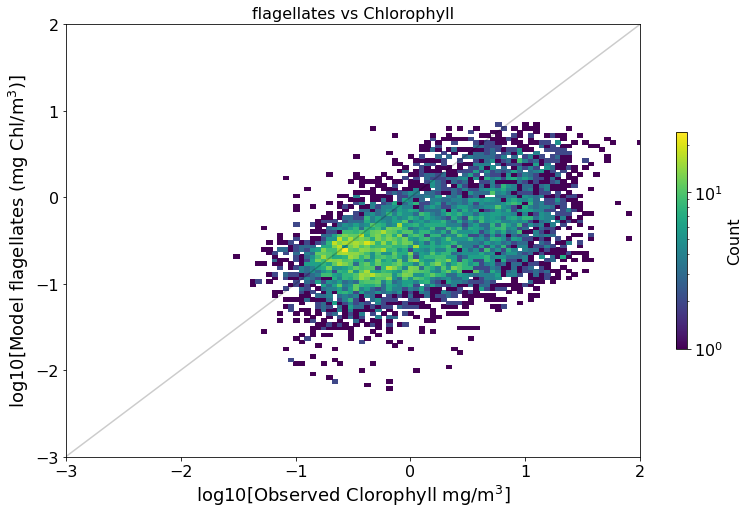

In [24]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data_Pheo,obsvar,modvar,(-3,2),fontsize=18)
ax.set_title('flagellates vs Chlorophyll')
ax.set_ylabel('log10[Model flagellates (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$]')  

### Model vs Observed comparisons for individual regions

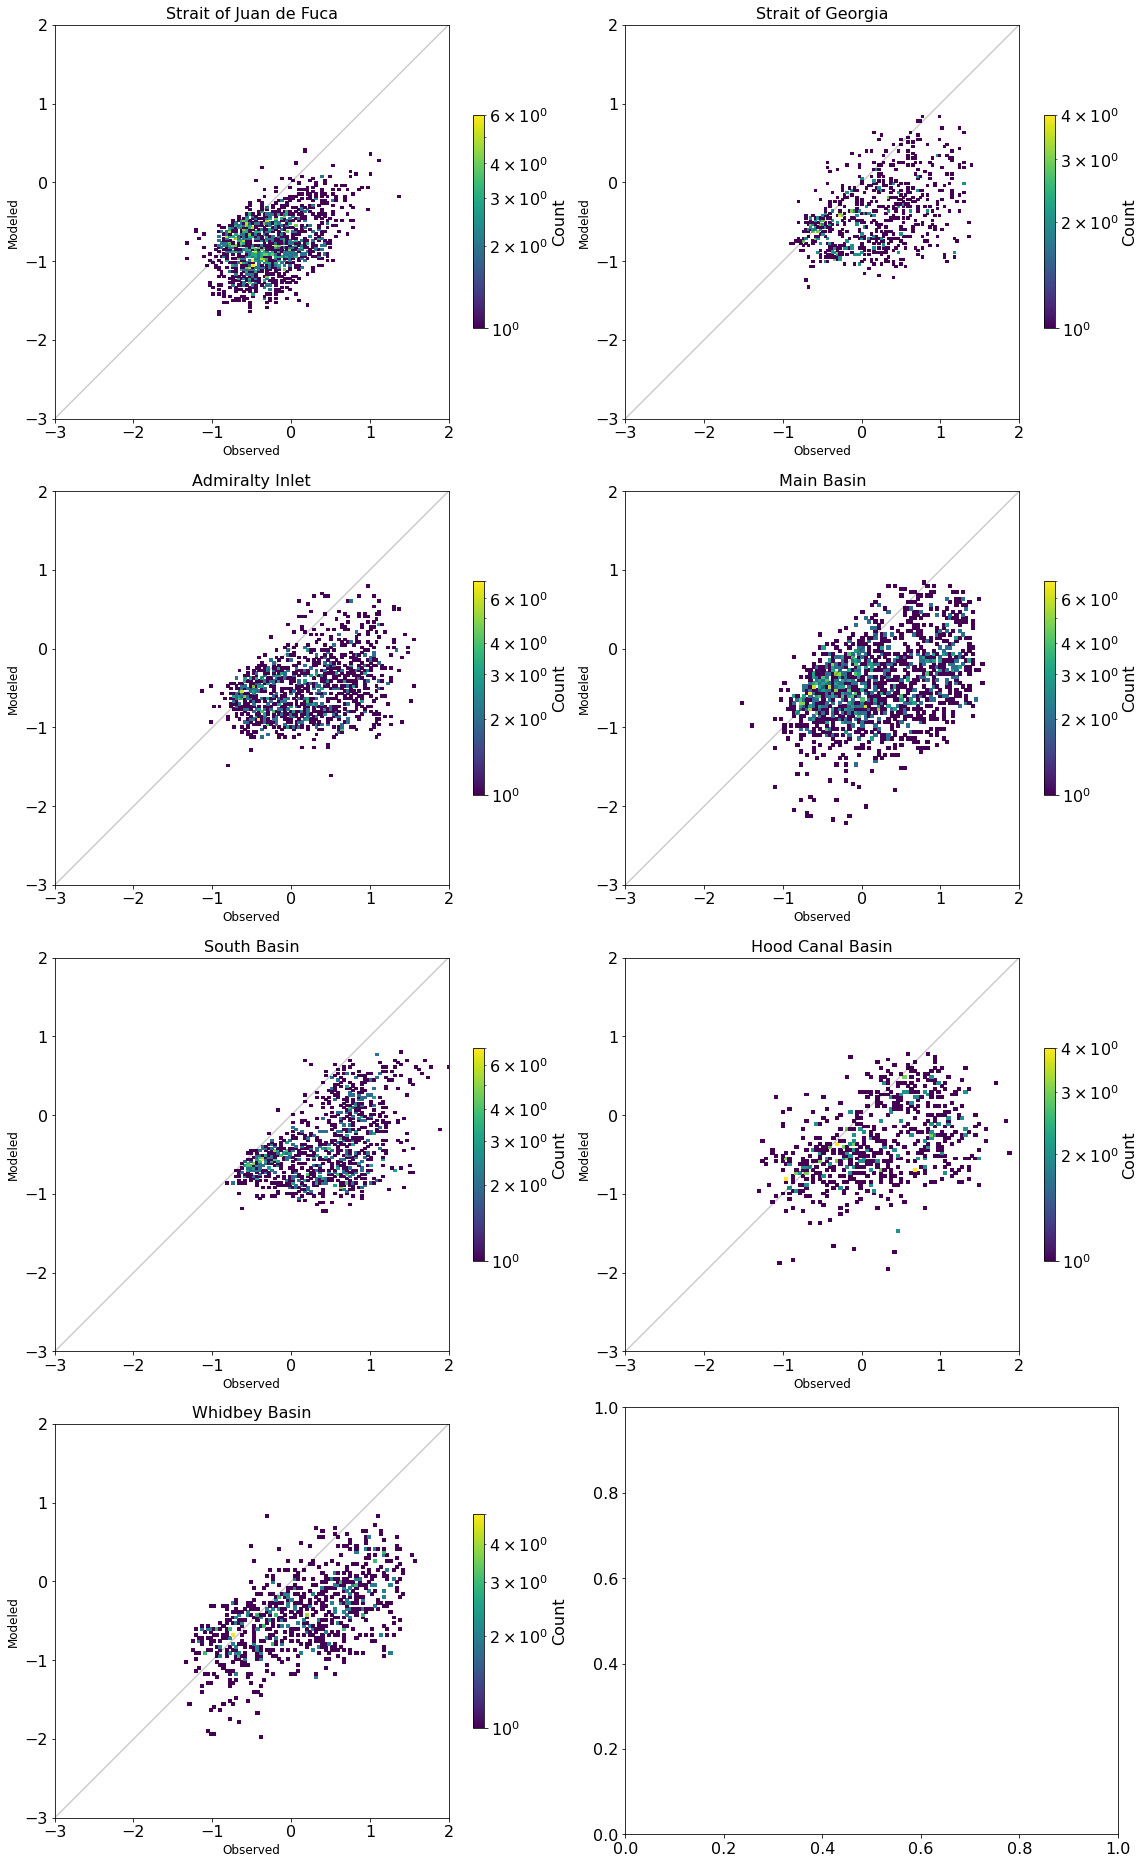

In [25]:
# Should alter to by region 2d histograms.
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(-3,2)
ax=ket.byRegion_hist2d(datreg_Pheo,regions,obsvar,modvar,lims)

### Model vs Observed comparisons for individual seasons

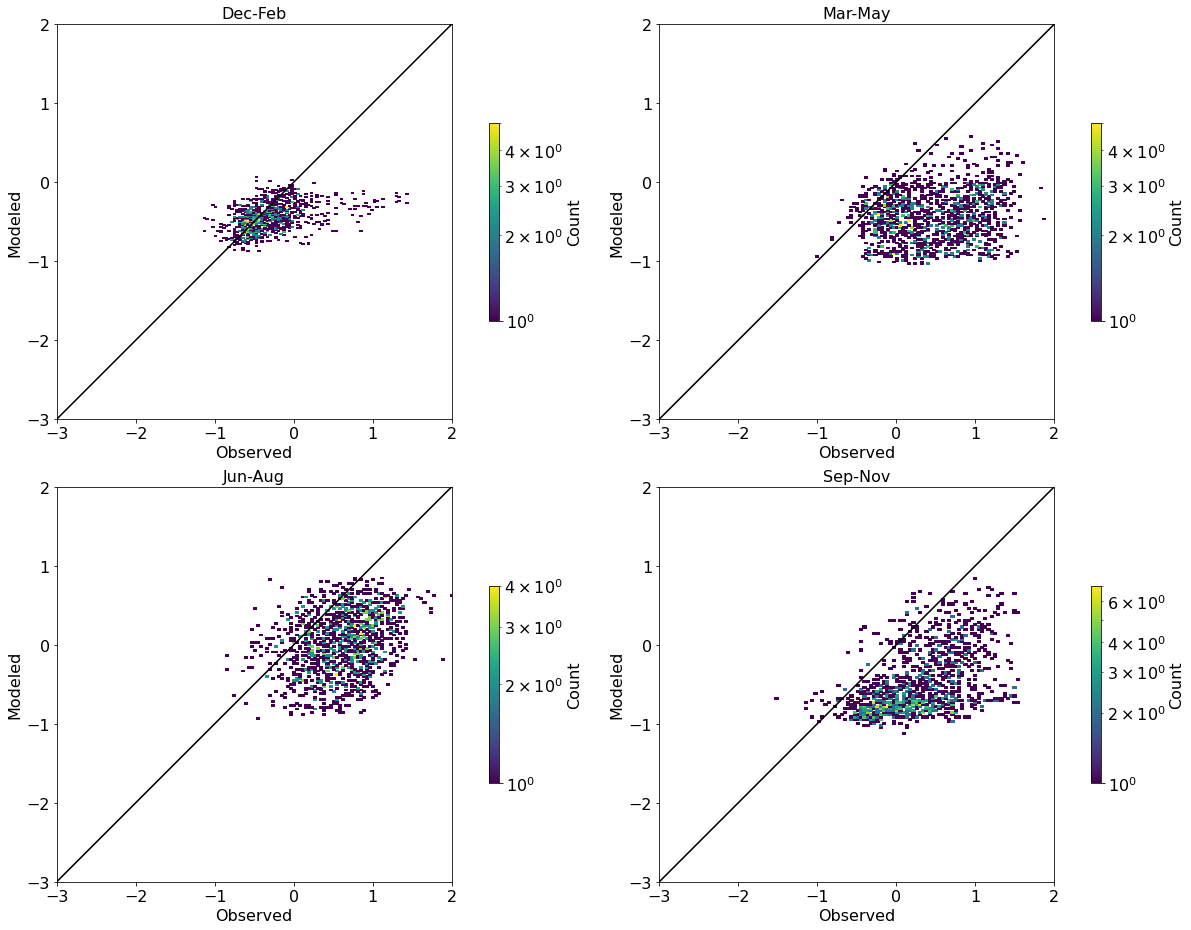

In [26]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(-3,2))
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

## All Model Phytoplankton vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [27]:
obsvar='Chla_Lab'
modvar='mod_Chl'

statsDict_Chl['All']=OrderedDict()
for isub in statsubs_Pheo:
    statsDict_Chl['All'][isub]=dict()
    var=statsDict_Chl['All'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_Pheo[isub].loc[:,[obsvar]], 
                                                                     statsubs_Pheo[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['All'],level='Subset',suborder=list(statsubs_Pheo.keys()))
tbl

## Model phytoplankton vs observed chlrophyll by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (Pheo)]')

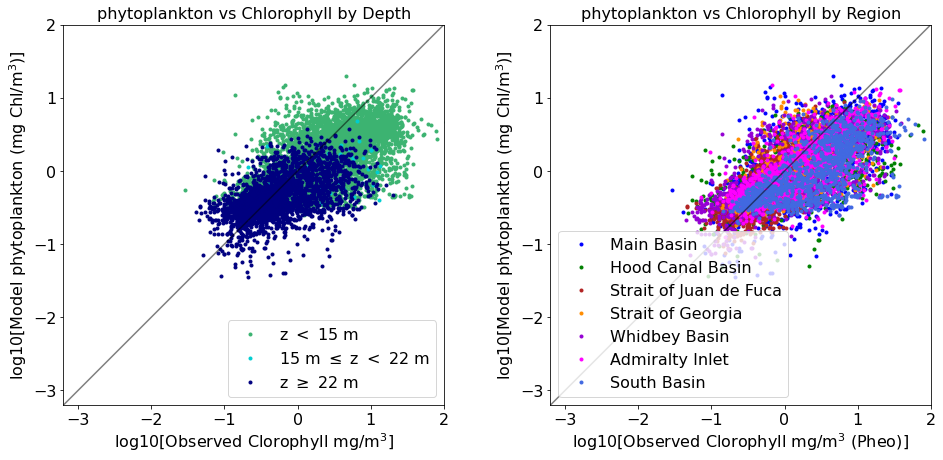

In [28]:
obsvar='log_Chl'
modvar='log_mod_Chl'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_Pheo,obsvar,modvar,mv)
ax[0].set_title('phytoplankton vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model phytoplankton (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$]')   

ps,l=ket.byRegion(ax[1],data_Pheo,datreg_Pheo,obsvar,modvar,mv)
ax[1].set_title('phytoplankton vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Model phytoplankton (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (Pheo)]') 

## 2D histogram of modeled vs observed data

Text(0.5, 37.0, 'log10[Observed Clorophyll mg/m$^3$]')

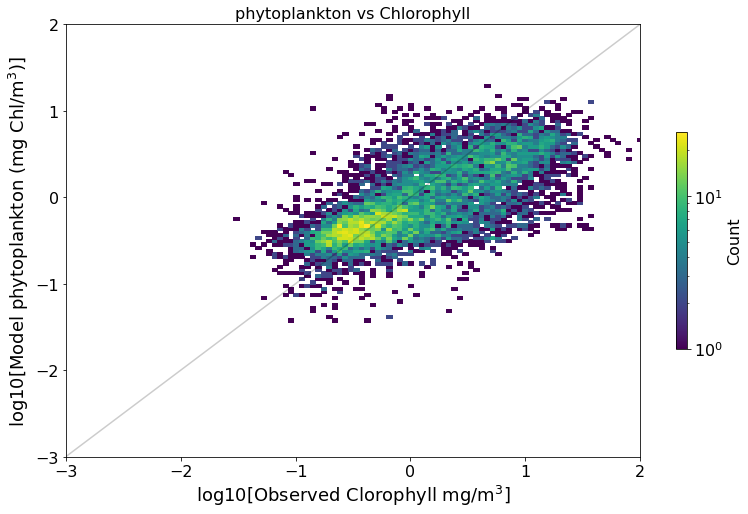

In [29]:
fig, ax = plt.subplots(1,1,figsize= (11,7))
ps = ket.hist2d(ax,fig,data_Pheo,obsvar,modvar,(-3,2),fontsize=18)
ax.set_title('phytoplankton vs Chlorophyll')
ax.set_ylabel('log10[Model phytoplankton (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$]')  

### Model vs Observed comparisons for individual regions

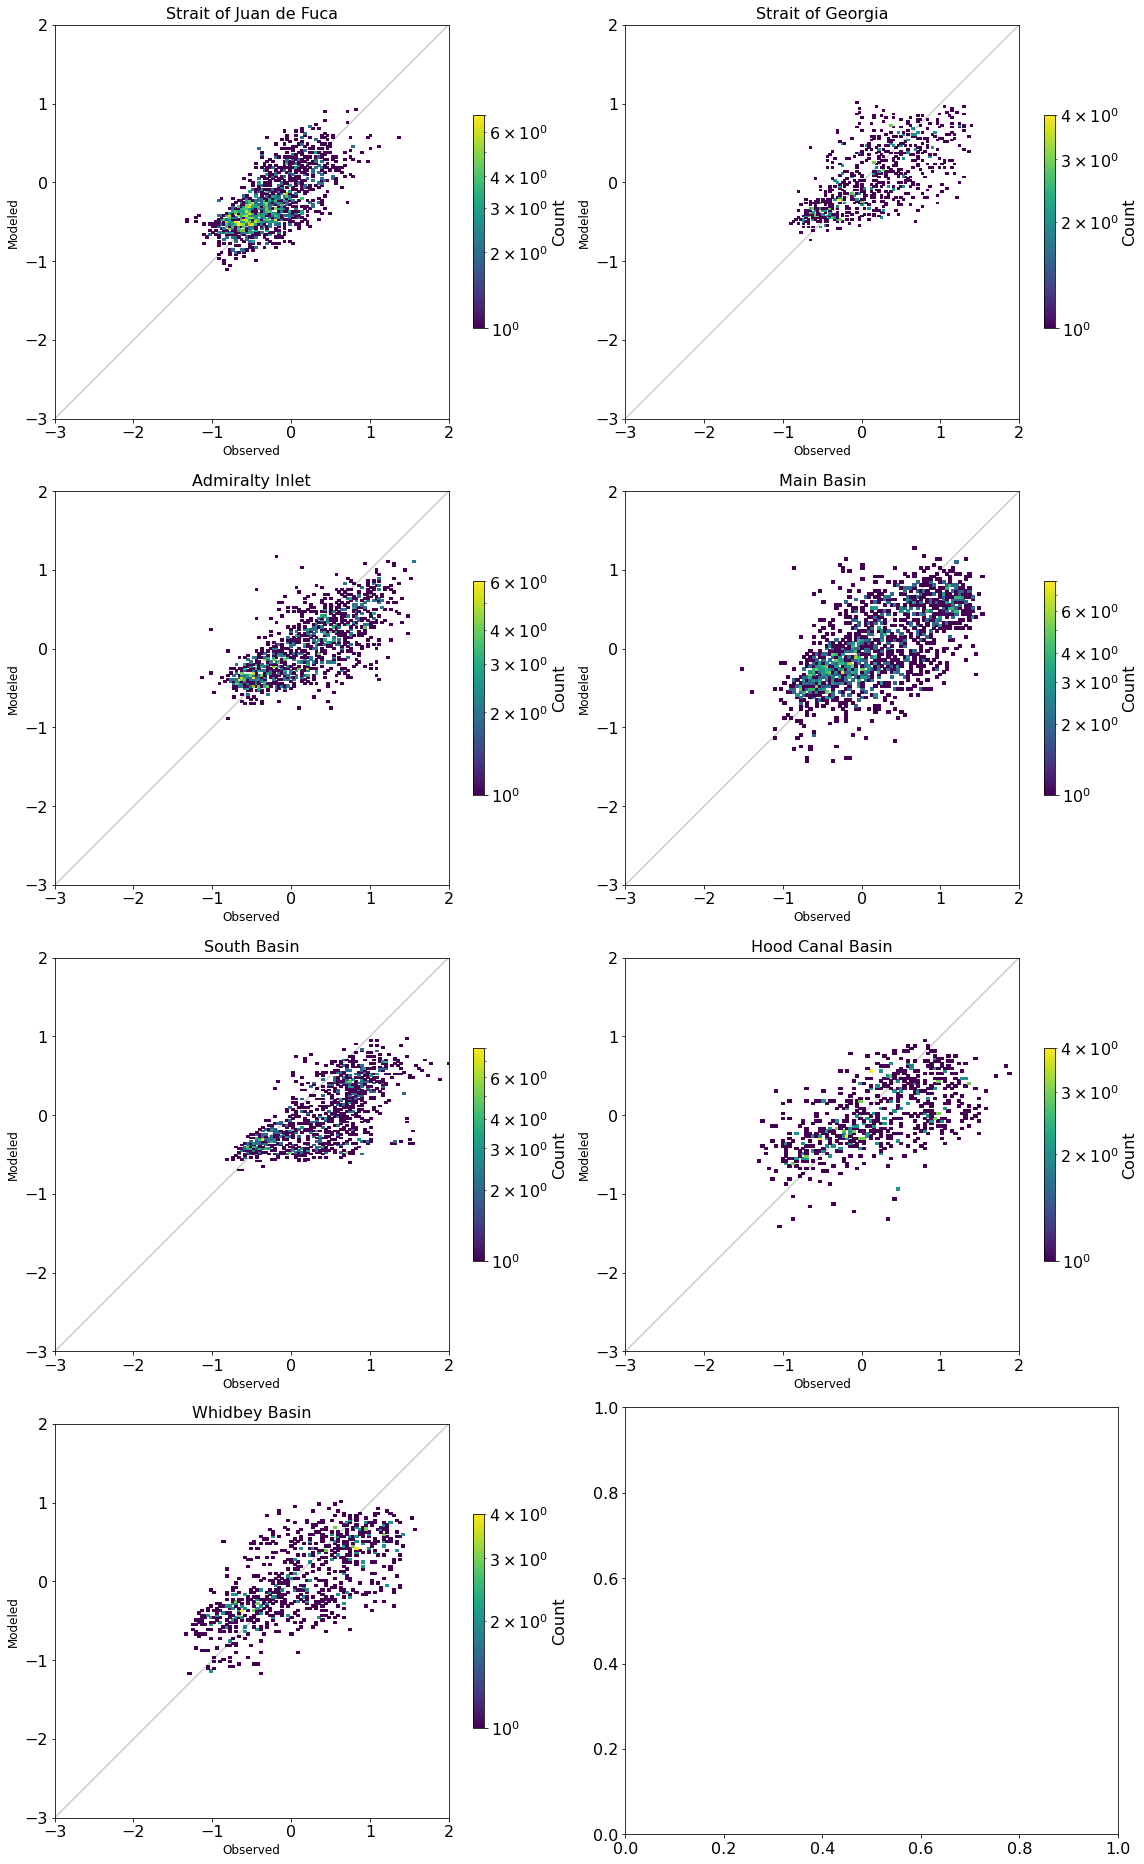

In [30]:
# Should alter to by region 2d histograms.
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(-3,2)
ax=ket.byRegion_hist2d(datreg_Pheo,regions,obsvar,modvar,lims)

### Model vs Observed comparisons for individual seasons

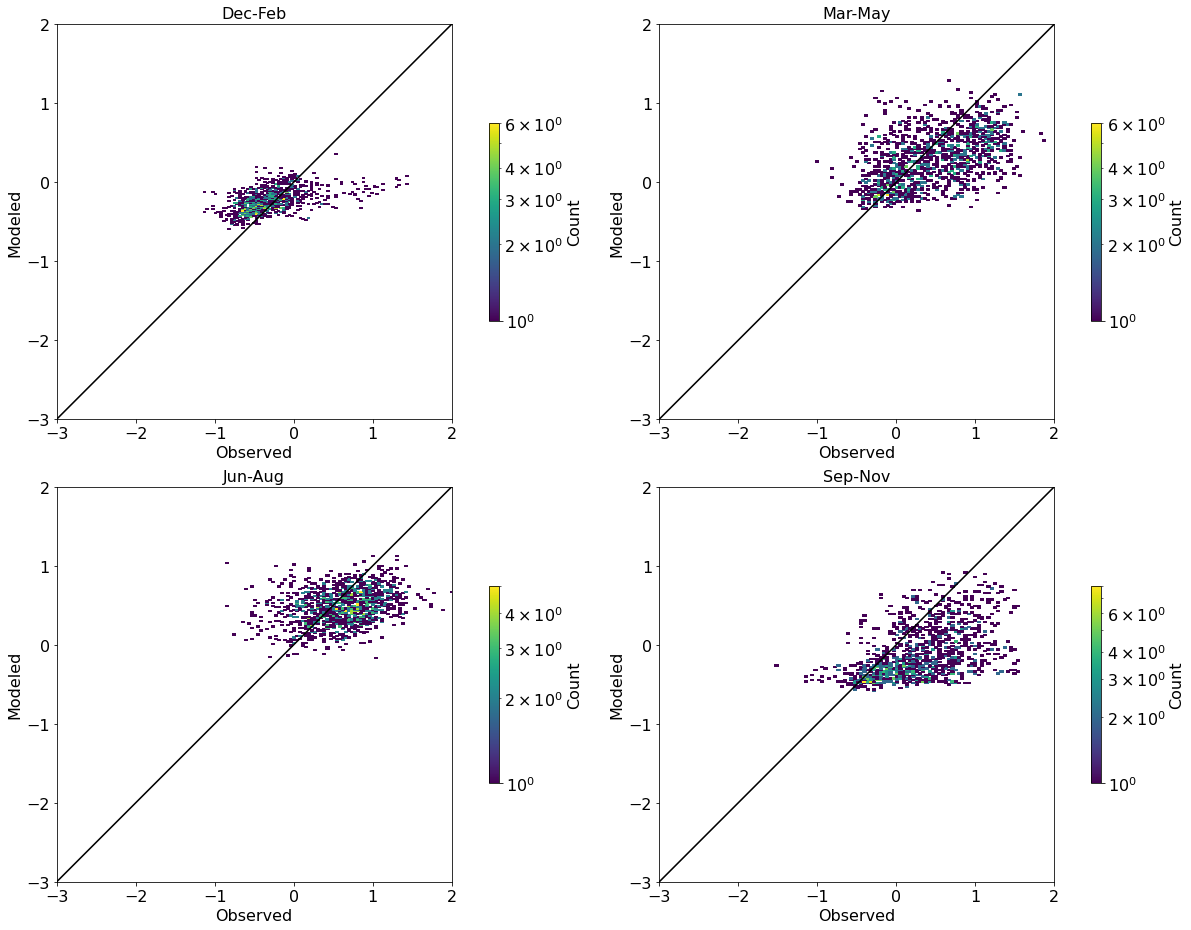

In [31]:
fig, ax = plt.subplots(2,2,figsize = (19,13))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(-3,2))
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Modeled',fontsize=16)
        ax[i][j].set_xlabel('Observed',fontsize=16)   

### Summary table of evaluation statistics for Temperature, Salinity, and Chlorophyll.

In [32]:
tbl,tdf=et.displayStats(statsDict_Chl,level='Variable',suborder=list(statsubs_Pheo.keys()))
tbl